## 1. Production of Machines

It costs a company 12 dollars to purchase an hour of labor and 15 dollars to purchase an hour of capital. If L hours of labor and K units of capital are available, then 0.05 L^(2/3)K^(1/3) machines can be produced. Suppose the company has $100,000 to purchase labor and capital. What is the maximum number of machines it can produce? Round to the nearest whole number of machines.

In [2]:
import numpy as np
from scipy.optimize import minimize

In [3]:
def machine(x):
    objective = 0.05 * (x[0]**(2/3)) *(x[1]**(1/3))
    
    return -objective

In [4]:
def confun(x):
    return 100000 - 12*x[0] - 15*x[1]

In [5]:
constr1 = {'type':'ineq', 'fun': confun}
constraints = [constr1]

In [6]:
machines_produced = minimize(machine,[2,2],constraints=constraints,tol=1e-8, bounds = [(0, 'inf'), (0, 'inf')])

In [7]:
machines_produced.x

array([5555.56148096, 2222.2174819 ])

In [8]:
round(-machines_produced.fun)

205

## 3. Variable Selection

The file **variable selection.csv** contains observations of variables y, x1, x2, and x3. Here, y is the dependent variable. We want to choose a linear model that uses at most two independent variables such that the sum of squared residuals is minimized. This can be formulated as a constrained quadratic programming problem.

This is called best subset problem that is usually very hard to solve. We will solve this problem by enumeration. Run six OLS regressions (3 with one independent variable and three more with two variables each) and choose the regression that best fits the data. You can run each regression using any regression tool you like.

Which variables are included?
1. x1
2. x2
3. x3

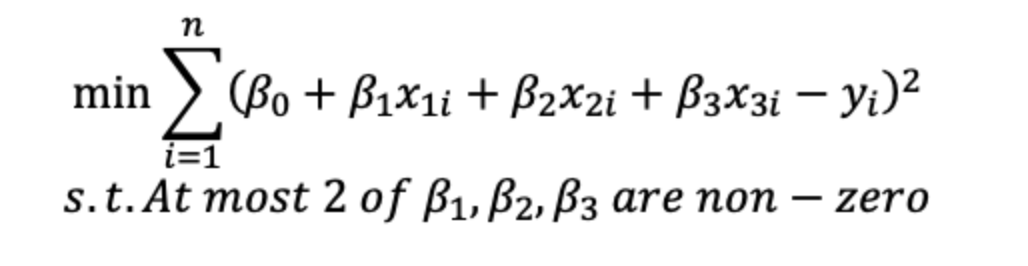

In [9]:
import pandas as pd
data = pd.read_csv("variable_selection.csv")

In [10]:
def objective_func_single_x1(coefs):
    b0, b1 = coefs
    y_pred = b0 + b1 * data['x1']
    return ((data['y'] - y_pred) ** 2).sum()

def objective_func_single_x2(coefs):
    b0, b1 = coefs
    y_pred = b0 + b1 * data['x2']
    return ((data['y'] - y_pred) ** 2).sum()

def objective_func_single_x3(coefs):
    b0, b1 = coefs
    y_pred = b0 + b1 * data['x3']
    return ((data['y'] - y_pred) ** 2).sum()

In [11]:
def objective_func_x1_x2(coefs):
    b0, b1, b2 = coefs
    y_pred = b0 + b1 * data['x1'] + b2 * data['x2']
    return ((data['y'] - y_pred) ** 2).sum()

def objective_func_x1_x3(coefs):
    b0, b1, b2 = coefs
    y_pred = b0 + b1 * data['x1'] + b2 * data['x3']
    return ((data['y'] - y_pred) ** 2).sum()

def objective_func_x2_x3(coefs):
    b0, b1, b2 = coefs
    y_pred = b0 + b1 * data['x2'] + b2 * data['x3']
    return ((data['y'] - y_pred) ** 2).sum()

In [12]:
results = {
    "x1": minimize(objective_func_single_x1, [0, 0]).fun,
    "x2": minimize(objective_func_single_x2, [0, 0]).fun,
    "x3": minimize(objective_func_single_x3, [0, 0]).fun,
    "x1_x2": minimize(objective_func_x1_x2, [0, 0, 0]).fun,
    "x1_x3": minimize(objective_func_x1_x3, [0, 0, 0]).fun,
    "x2_x3": minimize(objective_func_x2_x3, [0, 0, 0]).fun,
}

results

{'x1': 7901.299428781724,
 'x2': 878.8358232527938,
 'x3': 8575.63588048085,
 'x1_x2': 26.19087330164205,
 'x1_x3': 7860.088759733239,
 'x2_x3': 878.18105043677}

#### Variables included are : x1, x2

## 4. NFL Ratings

The file **nfratings.csv** contains the results of 256 regular-season NFL games from the 2009 season. The teams are indexed 1 to 32 as shown below.

The csv data file contains a matrix with the following columns:

    • Week (1-17)
    • Home Team Index (1-32 from the table below)
    • Visiting Team Index (1-32 from the table below)
    • Home Team Score
    • Visiting Team Score

For example, the first game in the matrix is team 25 Pittsburgh versus team 31 Tennessee, played at Pittsburgh. Pittsburgh won the game by a score of 13 to 10, and the point spread (home team score minus visitor team score) is 3. A positive point spread means that the home team won; a negative point spread indicates that the visiting team won.

The goal of this problem is to determine a set of ratings for the 32 NFL teams that most accurately predicts the actual outcomes of the games played, similar to homework 1. Here however, we will also incorporate a 'home field advantage' that adds some number of points to the predicted point spread. Use NLP to find the ratings that best predict the actual point spreads observed. The model will estimate the home team advantage and the ratings. The model accounts for the home team advantage by adding a constant (which you need to solve for) to the predicted point spread. The objective is to minimize the sum of squared prediction errors. You will need to calculate the following:

    • Actual Point Spread = Home Team Score - Visiting Team Score
    • Predicted Spread = Home Team Rating - Visitor Team Rating + Home Team Advantage
    • Prediction error = Actual Point Spread - Predicted Point Spread

Your goal is to minimize: 

$\sum_{\text{game}=1}^{256} \text{prediction} ({error^2_\text{game}})$

You will also need to normalize the ratings (like you did in HW 1). To do this, you set the actual average of the ratings to be 85 (this is somewhat arbitrary but based on the well-known Sagarin rating system). What do these ratings mean: If two teams had ratings of 82 and 91, then the second team would be predicted to win by 9 points if the game was played on a neutral field.
Formulate this as an NLP and solve it.

How many games (of the 256 played) does this model predict the winner correctly?

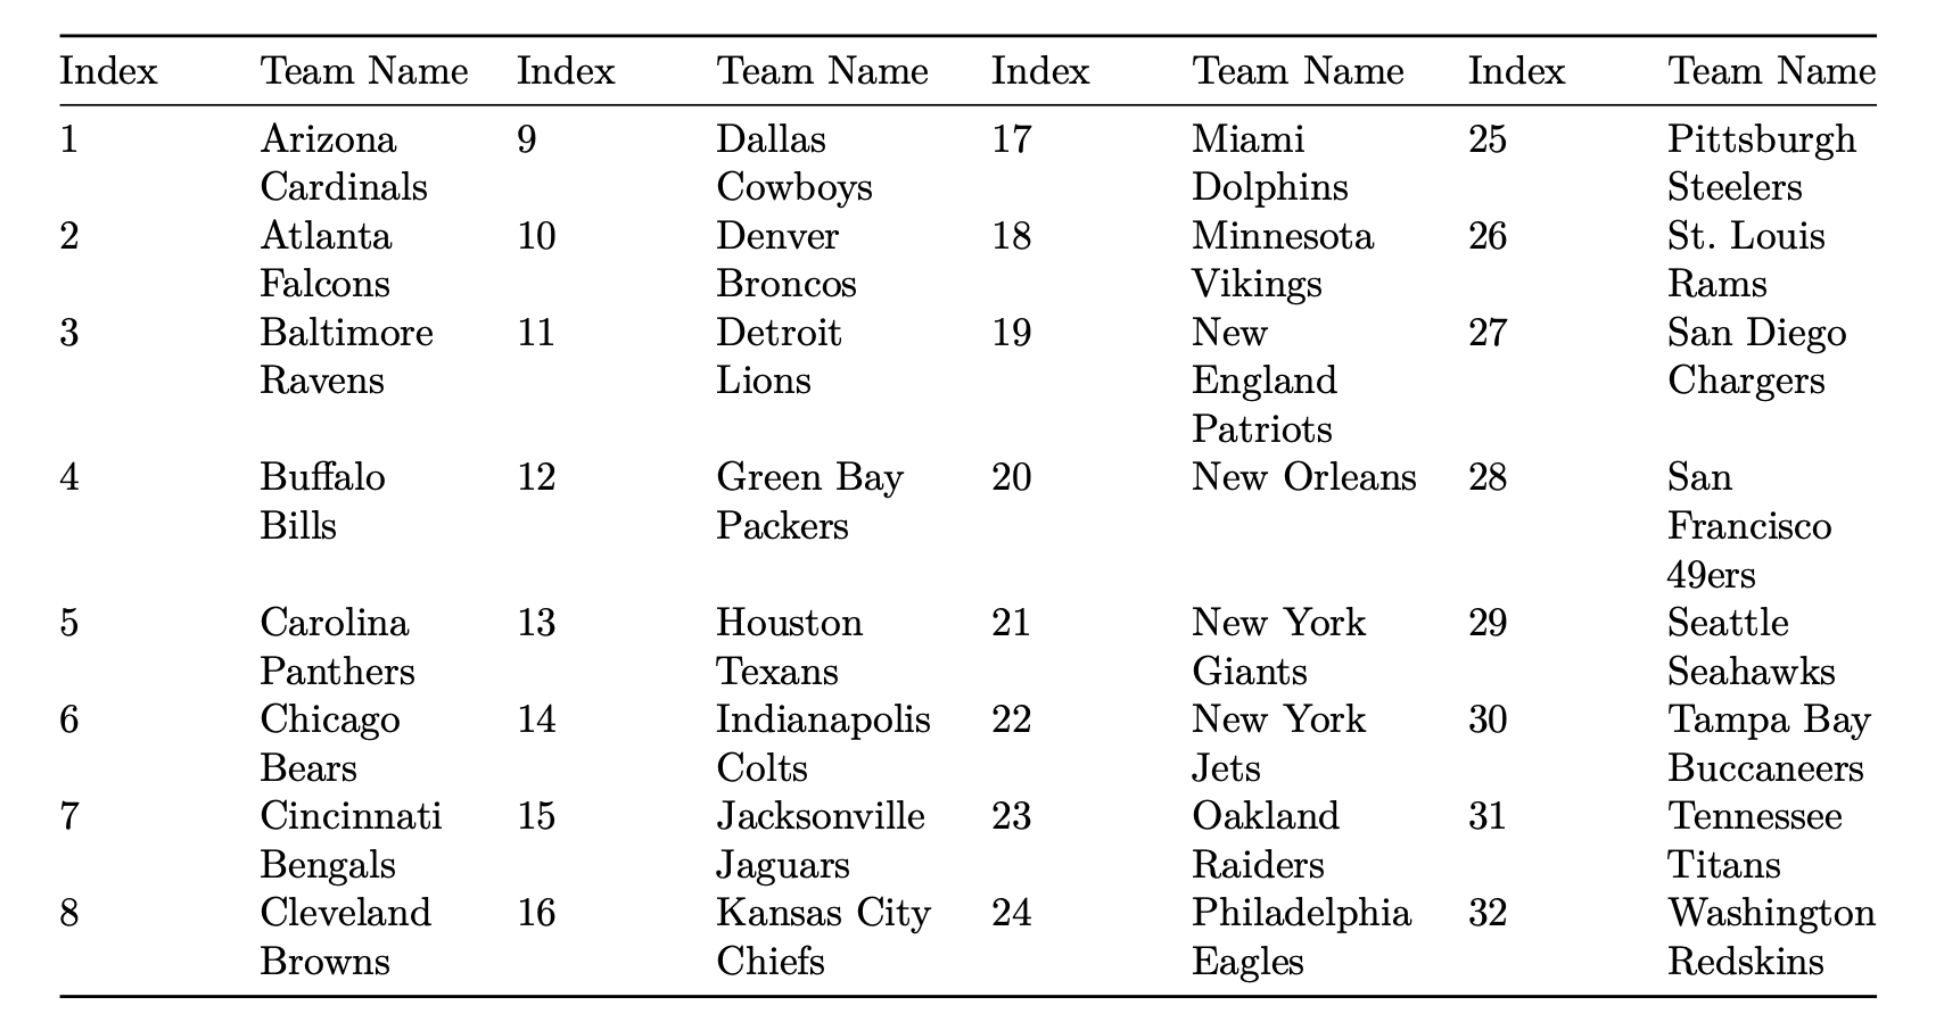

In [13]:
data_q4 = pd.read_csv("nflratings.csv")
data_q4.columns = [col.strip() for col in data_q4.columns]
data_q4.columns = ['Week', 'Home Team Index', 'Visiting Team Index', 'Home Team Score', 'Visiting Team Score']
data_q4['Actual Point Spread'] = data_q4['Home Team Score'] - data_q4['Visiting Team Score']

n_teams = 32

def objective(ratings_and_advantage):
    
    ratings = ratings_and_advantage[:-1]
    advantage = ratings_and_advantage[-1]

    home_indices = data_q4['Home Team Index'] - 1
    visiting_indices = data_q4['Visiting Team Index'] - 1

    predicted_spreads = ratings[home_indices] - ratings[visiting_indices] + advantage
    prediction_errors = data_q4['Actual Point Spread'] - predicted_spreads
    
    return np.sum(prediction_errors**2)

In [14]:
def constraint(ratings_and_advantage):
    ratings = ratings_and_advantage[:-1]
    return np.sum(ratings)/n_teams - 85

In [15]:
initial_guess = [85]*n_teams + [0]

con = {'type': 'eq', 'fun': constraint}

result = minimize(objective, initial_guess, constraints=con)


optimized_ratings = result.x[:-1]
home_advantage = result.x[-1]

In [16]:
data_q4['Predicted Spread'] = data_q4['Home Team Index'].apply(lambda x: optimized_ratings[x-1]) - \
                          data_q4['Visiting Team Index'].apply(lambda x: optimized_ratings[x-1]) + home_advantage

correct_predictions = np.sum(np.sign(data_q4['Actual Point Spread']) == np.sign(data_q4['Predicted Spread']))

print("Optimized Ratings: ",optimized_ratings)

print("Home Advantage:",home_advantage)

print("Correct Predictions:",correct_predictions)


Optimized Ratings:  [84.4881151  89.83320034 92.80494317 83.05017404 88.75187593 79.84047383
 87.60818491 76.94624929 92.13484193 85.67516335 70.53622958 92.28698171
 86.92185473 90.79962671 78.3770653  76.92758572 86.58733943 92.0962552
 96.08386508 95.62072808 85.11265292 93.10788782 75.07217588 90.97175719
 86.90868412 67.68743807 92.63440989 85.20757146 74.69678621 79.16296279
 81.90350342 80.16341681]
Home Advantage: 2.188054632644932
Correct Predictions: 180
